In [1]:
#!pip install kaggle

#import kaggle

# from kaggle.api.kaggle_api_extended import KaggleApi
# api=KaggleApi()
# api.authenticate()

#!kaggle datasets list -s 'Speaker'

#api.dataset_download_cli('vjcalling/speaker-recognition-audio-dataset/Speaker0026',unzip=True)

In [226]:
from scipy.io import wavfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.decomposition import FastICA, PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import IPython.display as ipd
import librosa
import librosa.display
import os
import wave
import ffmpeg
from scipy.io import wavfile
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras import Input
import keras

In [227]:
def mean_mfcc(speaker):    
    speaker_audio, sample_rate = librosa.load(str(speaker), res_type='kaiser_fast') 
    mfcc = librosa.feature.mfcc(y=speaker_audio, sr=sample_rate)
    mfcc_processed = np.mean(mfcc.T,axis=0)
    return mfcc_processed

In [ ]:
print(os.listdir("8_speakers_audio_data"))
speaker_audio, sample_rate = librosa.load("8_speakers_audio_data/Speaker0026/Speaker26_000.wav", res_type='kaiser_fast') 
mfcc = librosa.feature.mfcc(y=speaker_audio, sr=sample_rate)
print(mfcc.shape)

In [ ]:
column_names = ["Feature_1","Feature_2","Feature_3","Feature_4","Feature_5","Feature_6","Feature_7","Feature_8",
                "Feature_9","Feature_10","Feature_11","Feature_12","Feature_13","Feature_14","Feature_15","Feature_16",
                "Feature_17","Feature_18","Feature_19","Feature_20","Label"]

df = pd.DataFrame(columns = column_names)

for i, speaker in enumerate(os.listdir("8_speakers_audio_data")):
    features=[]
    for file in os.listdir("8_speakers_audio_data/"+str(speaker)):
        wav_file="8_speakers_audio_data/"+str(speaker)+"/"+str(file)
        data= mean_mfcc(wav_file)
        featuresdf = pd.DataFrame([data], columns=column_names[:-1])
        featuresdf.insert(1, "Label", "Speaker"+str(i), True)
        df = pd.concat([df, featuresdf],ignore_index = True)
df  

In [231]:
labelencoder = LabelEncoder()
df['Label'] = labelencoder.fit_transform(df['Label'])

In [232]:
df_shuffled=df.sample(frac=1,random_state = 0).reset_index(drop=True)

In [233]:
feature_df = df_shuffled.drop(columns=["Label"], axis=1)
label = df_shuffled.iloc[:,-1]

In [234]:
X_train, X_test, y_train, y_test = train_test_split(feature_df, label, test_size=0.30, random_state=0)

In [235]:
X_train.head()

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,Feature_11,Feature_12,Feature_13,Feature_14,Feature_15,Feature_16,Feature_17,Feature_18,Feature_19,Feature_20
208,-385.701019,77.004326,3.292691,20.927261,9.072340,12.528959,-17.228025,-11.073611,-18.435623,-1.888671,-19.644821,-1.187396,-5.088173,-1.859888,-7.555277,-2.143244,-11.212361,-6.179951,-6.961442,-5.939736
181,-391.118561,79.738045,21.913794,27.952974,15.405539,-4.898401,-21.323311,12.404000,-5.671783,11.470372,2.273908,-6.402997,-4.000299,12.291221,-7.339770,8.848000,-6.560680,0.239585,-4.264799,0.900290
291,-374.863983,100.847786,-5.568498,43.977154,9.984566,1.269493,-9.024014,-5.862720,5.627461,6.818155,-1.940416,5.238012,-1.964907,0.113761,0.242994,4.934378,-0.489824,3.434231,6.884135,2.797388
108,-382.327118,57.928036,-16.590021,10.353060,-16.310089,-14.719978,-20.601061,-27.733536,-12.384237,-4.342675,-13.045654,-6.375424,-5.580319,1.122252,-7.180358,-2.341331,-3.340183,-6.828104,-7.478609,-1.370697
215,-369.777069,105.813805,5.089341,21.899603,7.969273,7.626025,-21.504213,6.546567,-5.687978,-8.957321,6.474492,4.388157,-8.312148,2.646343,-0.022112,5.120378,-1.701252,1.592715,-0.141098,2.719436


In [236]:
y_train_1 = np.array(y_train)
y_test_1 = np.array(y_test)

In [237]:
y_1 = to_categorical(y_train_1)
y_2 = to_categorical(y_test_1)

In [ ]:
y_1

In [347]:
def build_model_graph(input_shape=(20,)):
    ## 20 20 20 8
    model = Sequential(name="Fully_Connected_Layer") # Model
    model.add(Input(shape=(20,), name='Input-Layer')) # Input Layer - need to speicfy the shape of inputs
    model.add(Dense(40, activation='relu', name='Hidden-Layer_1')) # Hidden Layer, ReLU
    model.add(Dropout(0.2))
    model.add(Dense(40,  activation='relu', name='Hidden-Layer_2')) # Hidden Layer, ReLU
    model.add(Dropout(0.2))
    model.add(Dense(8, activation='softmax', name='Output-Layer')) # Output Layer, Softmax
    model.compile(loss='categorical_crossentropy', metrics=['Accuracy', 'Precision', 'Recall', tf.keras.metrics.AUC()], optimizer='adam')
    return model
model = build_model_graph()

In [348]:
# Display model architecture summary 
model.summary()
X_train_1 = np.asarray(X_train.values.tolist(), dtype=object).astype(np.float32)
#y_1 = np.asarray(y_train.values.tolist(), dtype=object).astype(np.float32)
X_test_1 = np.asarray(X_test.values.tolist(), dtype=object).astype(np.float32)
#y_2 = np.asarray(y_test.values.tolist(), dtype=object).astype(np.float32)
# Calculate pre-training accuracy 



Model: "Fully_Connected_Layer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Hidden-Layer_1 (Dense)       (None, 40)                840       
_________________________________________________________________
dropout_27 (Dropout)         (None, 40)                0         
_________________________________________________________________
Hidden-Layer_2 (Dense)       (None, 40)                1640      
_________________________________________________________________
dropout_28 (Dropout)         (None, 40)                0         
_________________________________________________________________
Output-Layer (Dense)         (None, 8)                 328       
Total params: 2,808
Trainable params: 2,808
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_ann=model.fit(X_train_1, y_1, batch_size=40, epochs=1000, validation_data=(X_test_1, y_2), verbose=1)

In [300]:
score_train = model.evaluate(X_train_1, y_1, verbose=0)
print("Training Accuracy: {0:.2%}".format(score_train[1]))
print("Precision Accuracy: {0:.2%}".format(score_train[2]))
print("Recall Accuracy: {0:.2%}".format(score_train[3]))

Training Accuracy: 100.00%
Precision Accuracy: 100.00%
Recall Accuracy: 100.00%


In [301]:
score_test = model.evaluate(X_test_1, y_2, verbose=0)
print("Testing Accuracy: {0:.2%}".format(score_test[1]))
print("Precision Accuracy: {0:.2%}".format(score_test[2]))
print("Recall Accuracy: {0:.2%}".format(score_test[3]))

Testing Accuracy: 97.03%
Precision Accuracy: 97.03%
Recall Accuracy: 97.03%


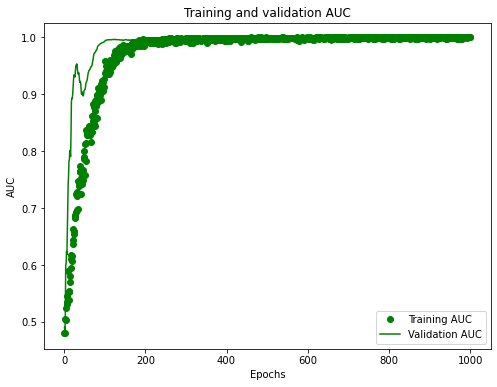

In [355]:
# Plot the accuracy curves for training and validation.
history_val=history_ann.history
acc_values = history_val['auc_2']
val_acc_values = history_val['val_auc_2']
epochs = range(1, 1001)

plt.figure(figsize=(8,6))
plt.plot(epochs, acc_values, 'go', label='Training AUC')
plt.plot(epochs, val_acc_values, 'g', label='Validation AUC')
plt.title('Training and validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.show()

## CNN

In [318]:
# Set paths to input and output data
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import wave
import pylab
from pathlib import Path
from scipy import signal
from scipy.io import wavfile
from sklearn.metrics import confusion_matrix
import itertools
INPUT_DIR = '8_speakers_audio_data'
OUTPUT_DIR = "./"

In [319]:
def get_wav_info(wav_file):
    wav = wave.open(wav_file, 'r')
    frames = wav.readframes(-1)
    sound_info = pylab.frombuffer(frames, 'int16')
    frame_rate = wav.getframerate()
    wav.close()
    return sound_info, frame_rate

In [320]:
for i, speaker in enumerate(os.listdir("8_speakers_audio_data")):
    target_dir = 'class_'+str(i)
    dist_dir = os.path.join('audio-images', target_dir)
    dist_dir=dist_dir.replace('\\','/')
    for file in os.listdir("8_speakers_audio_data/"+str(speaker)):
        wav_file="8_speakers_audio_data/"+str(speaker)+"/"+str(file)
        file=file.replace('.wav','')
        if not os.path.exists(dist_dir+"/"+file+".png"):
            if not os.path.exists(dist_dir):
                os.makedirs(dist_dir)
            sound_info, frame_rate = get_wav_info(wav_file)
            pylab.specgram(sound_info, Fs=frame_rate, NFFT=51200)
            pylab.savefig(dist_dir+"/"+file+".png")
            pylab.close()

In [321]:
# Print the ten classes in our dataset
path_list = os.listdir(os.path.join(OUTPUT_DIR, 'audio-images'))
print("Classes: \n")
for i in range(8):
    print(path_list[i])

Classes: 

class_0
class_1
class_2
class_3
class_4
class_5
class_6
class_7


In [322]:
# Declare constants
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64
BATCH_SIZE = 32
N_CHANNELS = 3
N_CLASSES = 8

# Make a dataset containing the training spectrograms
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=BATCH_SIZE,
                                             validation_split=0.2,
                                             directory=os.path.join(OUTPUT_DIR, 'audio-images'),
                                             shuffle=True,
                                             color_mode='rgb',
                                             image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                             subset="training",
                                             seed=0)

Found 334 files belonging to 8 classes.
Using 268 files for training.


In [323]:
# Make a dataset containing the validation spectrogram
valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=BATCH_SIZE,
                                             validation_split=0.2,
                                             directory=os.path.join(OUTPUT_DIR, 'audio-images'),
                                             shuffle=True,
                                             color_mode='rgb',
                                             image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                             subset="validation",
                                             seed=0)


Found 334 files belonging to 8 classes.
Using 66 files for validation.


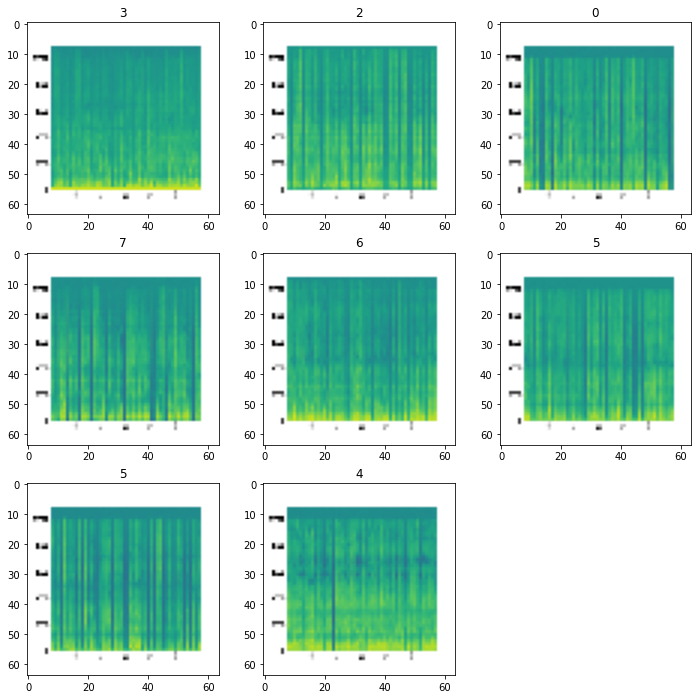

In [324]:
plt.figure(figsize=(12, 12))
for images, labels in train_dataset.take(1):
    for i in range(8):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis()

In [325]:
# Function to prepare our datasets for modelling
def prepare(ds, augment=False):
    # Define our one transformation
    rescale = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.Rescaling(1./255)])
    flip_and_rotate = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
    ])
    
    # Apply rescale to both datasets and augmentation only to training
    ds = ds.map(lambda x, y: (rescale(x, training=True), y))
    if augment: ds = ds.map(lambda x, y: (flip_and_rotate(x, training=True), y))
    return ds

train_dataset = prepare(train_dataset, augment=False)
valid_dataset = prepare(valid_dataset, augment=False)

In [326]:
# Create CNN model
model_cnn = tf.keras.models.Sequential()
model_cnn.add(tf.keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, N_CHANNELS)))
model_cnn.add(tf.keras.layers.Conv2D(16, (11,3), strides=(1,3), padding='same', activation='relu'))
model_cnn.add(tf.keras.layers.BatchNormalization())
model_cnn.add(tf.keras.layers.MaxPooling2D(pool_size=(4, 2)))
model_cnn.add(tf.keras.layers.BatchNormalization())
model_cnn.add(tf.keras.layers.Conv2D(32, (11,3), strides=(1,3), padding='same', activation='relu'))
model_cnn.add(tf.keras.layers.BatchNormalization())
model_cnn.add(tf.keras.layers.MaxPooling2D(pool_size=(4, 2)))
model_cnn.add(tf.keras.layers.BatchNormalization())
model_cnn.add(tf.keras.layers.Flatten())
model_cnn.add(tf.keras.layers.Dense(64, activation='relu'))
model_cnn.add(tf.keras.layers.BatchNormalization())
model_cnn.add(tf.keras.layers.Dropout(0.2))
model_cnn.add(tf.keras.layers.Dense(N_CLASSES, activation='softmax'))

In [ ]:
# Compile model
model_cnn.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
    metrics=['accuracy']
)

# Train model for 10 epochs, capture the history
history = model_cnn.fit(train_dataset, epochs=100, validation_data=valid_dataset)

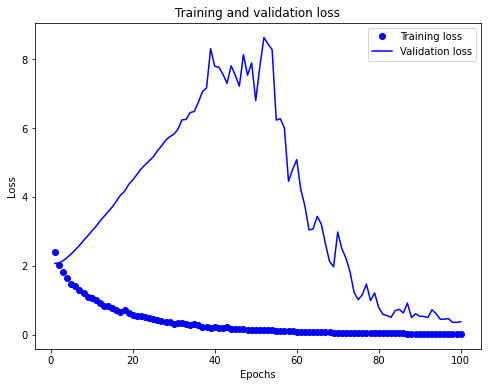

In [328]:
# Plot the loss curves for training and validation.
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, 101)

plt.figure(figsize=(8,6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

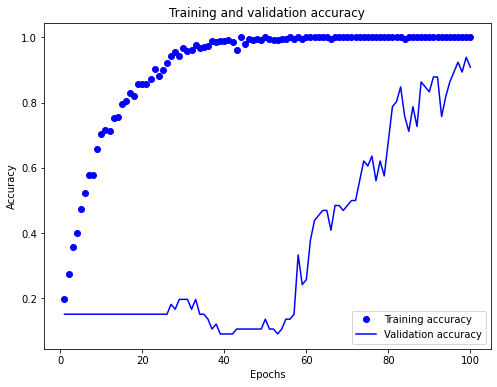

In [329]:
# Plot the accuracy curves for training and validation.
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, 101)

plt.figure(figsize=(8,6))
plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [331]:
final_loss, final_acc = model_cnn.evaluate(valid_dataset, verbose=0)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))

Final loss: 0.382701, final accuracy: 0.909091


## FAST ICA

In [257]:
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.decomposition import FastICA, PCA
import wave
import librosa
from sklearn import preprocessing

In [258]:
rate0, data_speaker0 = wavfile.read("8_speakers_audio_data/Speaker0026/Speaker26_000.wav")
rate1, data_speaker1 = wavfile.read("8_speakers_audio_data/Speaker0027/Speaker27_000.wav")
rate2, data_speaker2 = wavfile.read("8_speakers_audio_data/Speaker0028/Speaker28_000.wav")
rate3, data_speaker3 = wavfile.read("8_speakers_audio_data/Speaker0029/Speaker29_000.wav")
rate4, data_speaker4 = wavfile.read("8_speakers_audio_data/Speaker0030/Speaker30_000.wav")
rate5, data_speaker5 = wavfile.read("8_speakers_audio_data/Speaker0031/Speaker31_000.wav")
rate6, data_speaker6 = wavfile.read("8_speakers_audio_data/Speaker0032/Speaker32_000.wav")
rate7, data_speaker7 = wavfile.read("8_speakers_audio_data/Speaker0033/Speaker0033_000.wav")

In [259]:
def mixSounds(speakers_list, weights):
    """ Return a sound array mixed in proportion with the ratios given by weights"""
    mixed_audio = np.zeros(len(speakers_list[0]))
    i = 0
    for speaker in speakers_list:
        mixed_audio += speaker*weights[i]
        i += 1

    return mixed_audio 

In [260]:
mixed_sound_A = mixSounds([data_speaker0, data_speaker1, data_speaker2, data_speaker3, data_speaker4, data_speaker5, data_speaker6, data_speaker7], np.random.random(8)).astype(np.int16)
mixed_sound_B = mixSounds([data_speaker0, data_speaker1, data_speaker2, data_speaker3, data_speaker4, data_speaker5, data_speaker6, data_speaker7], np.random.random(8)).astype(np.int16)
mixed_sound_C = mixSounds([data_speaker0, data_speaker1, data_speaker2, data_speaker3, data_speaker4, data_speaker5, data_speaker6, data_speaker7], np.random.random(8)).astype(np.int16)
mixed_sound_D = mixSounds([data_speaker0, data_speaker1, data_speaker2, data_speaker3, data_speaker4, data_speaker5, data_speaker6, data_speaker7], np.random.random(8)).astype(np.int16)
mixed_sound_E = mixSounds([data_speaker0, data_speaker1, data_speaker2, data_speaker3, data_speaker4, data_speaker5, data_speaker6, data_speaker7], np.random.random(8)).astype(np.int16)
mixed_sound_F = mixSounds([data_speaker0, data_speaker1, data_speaker2, data_speaker3, data_speaker4, data_speaker5, data_speaker6, data_speaker7], np.random.random(8)).astype(np.int16)
mixed_sound_G = mixSounds([data_speaker0, data_speaker1, data_speaker2, data_speaker3, data_speaker4, data_speaker5, data_speaker6, data_speaker7], np.random.random(8)).astype(np.int16)
mixed_sound_H = mixSounds([data_speaker0, data_speaker1, data_speaker2, data_speaker3, data_speaker4, data_speaker5, data_speaker6, data_speaker7], np.random.random(8)).astype(np.int16)

In [ ]:
wavfile.write("mixed_sound_A.wav", rate0, mixed_sound_A)
ipd.Audio("mixed_sound_A.wav")

In [ ]:
wavfile.write("mixed_sound_B.wav", rate0, mixed_sound_B)
ipd.Audio("mixed_sound_B.wav")

In [263]:
signal = np.c_[mixed_sound_A, mixed_sound_B, mixed_sound_C, mixed_sound_D, mixed_sound_E, mixed_sound_F, mixed_sound_G, mixed_sound_H]

In [264]:
# Initialize FastICA with n_components=2
ica = FastICA(n_components=8)

# Run the FastICA algorithm using fit_transform on dataset signal
ica_result = ica.fit_transform(signal)

In [265]:
ica_result.shape

(1323008, 8)

In [266]:
result_signal_0 = ica_result[:,0]*2000000
result_signal_1 = ica_result[:,1]*2000000
result_signal_2 = ica_result[:,2]*2000000
result_signal_3 = ica_result[:,3]*2000000
result_signal_4 = ica_result[:,4]*2000000
result_signal_5 = ica_result[:,5]*2000000
result_signal_6 = ica_result[:,6]*2000000
result_signal_7 = ica_result[:,7]*2000000

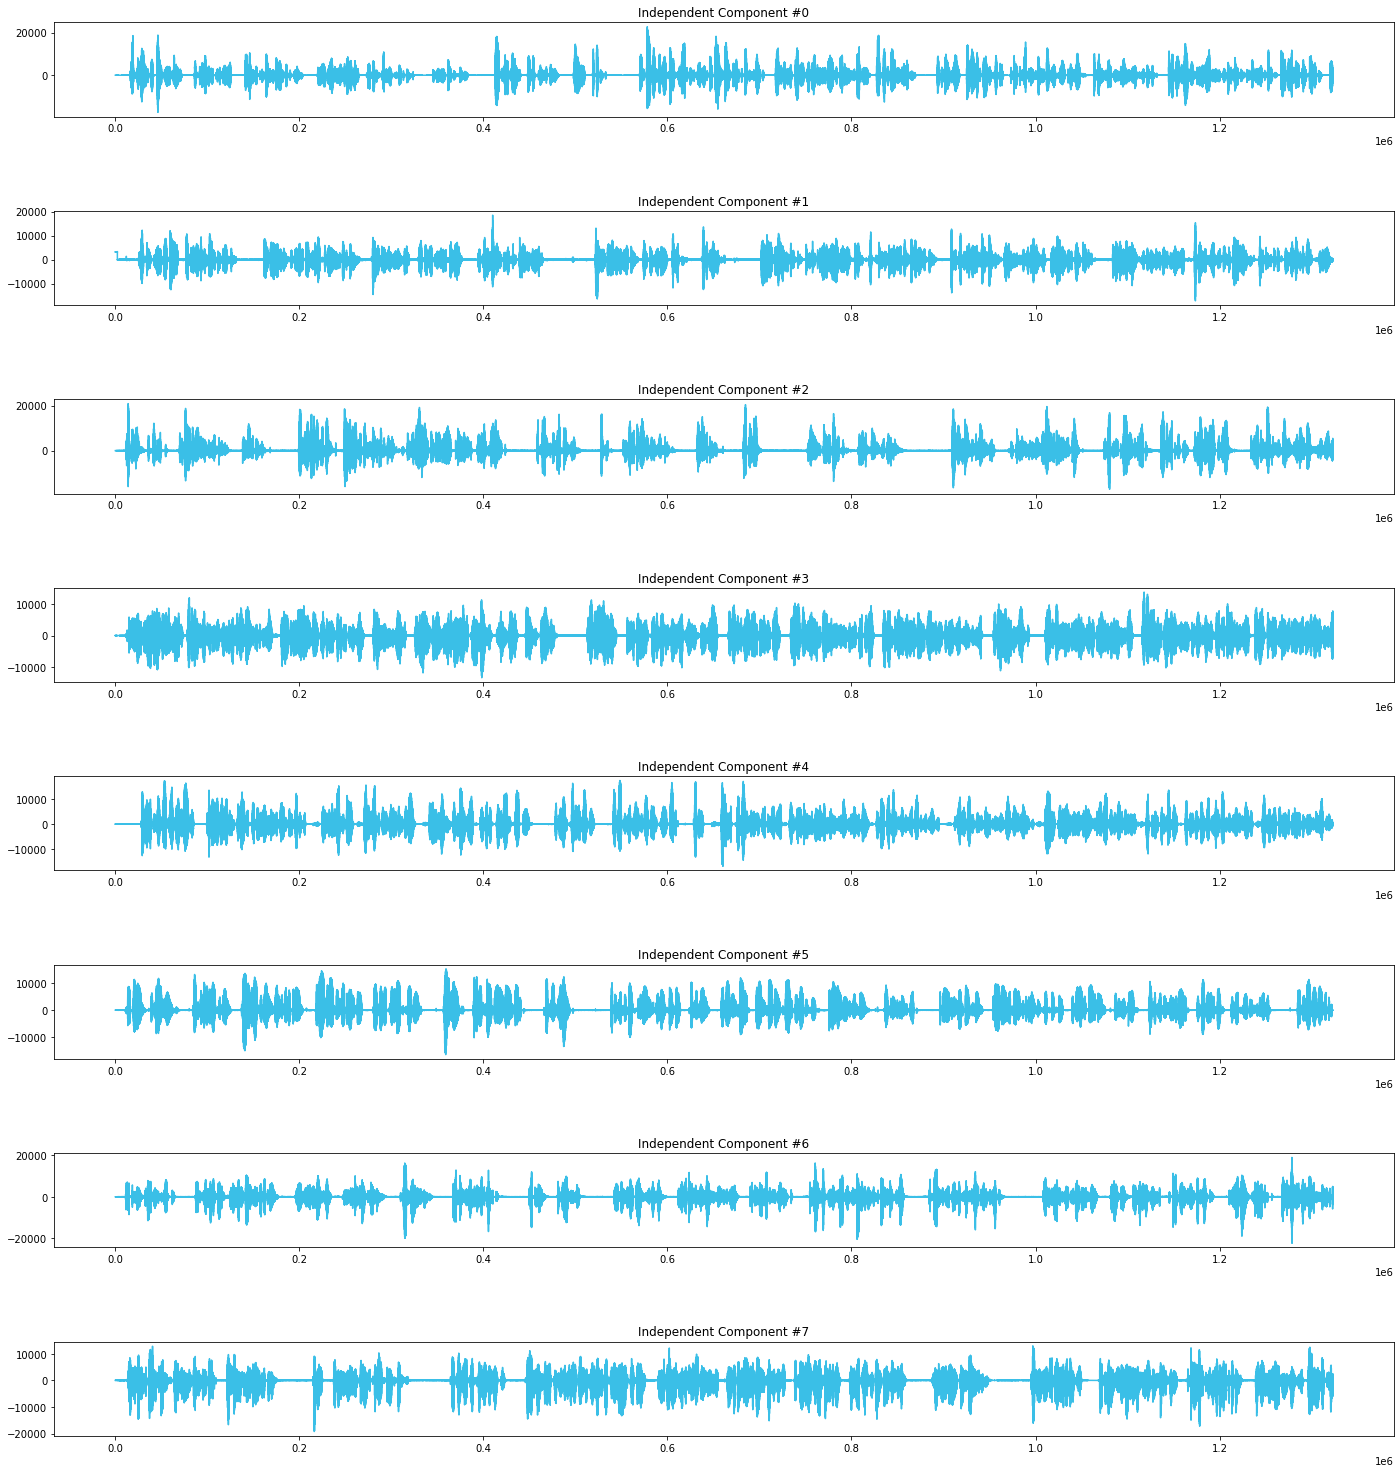

In [267]:
# Plot Independent Component #1
plt.figure(figsize=(24,26))

fig = plt.subplot(8, 1, 1)
plt.title('Independent Component #0')
plt.plot(result_signal_0, c="#3ABFE7")

fig = plt.subplot(8, 1, 2)
plt.title('Independent Component #1')
plt.plot(result_signal_1, c="#3ABFE7")

fig = plt.subplot(8, 1, 3)
plt.title('Independent Component #2')
plt.plot(result_signal_2, c="#3ABFE7")

fig = plt.subplot(8, 1, 4)
plt.title('Independent Component #3')
plt.plot(result_signal_3, c="#3ABFE7")

fig = plt.subplot(8, 1, 5)
plt.title('Independent Component #4')
plt.plot(result_signal_4, c="#3ABFE7")

fig = plt.subplot(8, 1, 6)
plt.title('Independent Component #5')
plt.plot(result_signal_5, c="#3ABFE7")

fig = plt.subplot(8, 1, 7)
plt.title('Independent Component #6')
plt.plot(result_signal_6, c="#3ABFE7")

fig = plt.subplot(8, 1, 8)
plt.title('Independent Component #7')
plt.plot(result_signal_7, c="#3ABFE7")

plt.subplots_adjust(hspace=1)
plt.show()

In [268]:
wavfile.write("independent_component_0.wav", rate2, result_signal_0.astype(np.int16))
wavfile.write("independent_component_1.wav", rate1, result_signal_1.astype(np.int16))
wavfile.write("independent_component_2.wav", rate2, result_signal_2.astype(np.int16))
wavfile.write("independent_component_3.wav", rate1, result_signal_3.astype(np.int16))
wavfile.write("independent_component_4.wav", rate2, result_signal_4.astype(np.int16))
wavfile.write("independent_component_5.wav", rate1, result_signal_5.astype(np.int16))
wavfile.write("independent_component_6.wav", rate2, result_signal_6.astype(np.int16))
wavfile.write("independent_component_7.wav", rate1, result_signal_7.astype(np.int16))

In [269]:
components_list = ["independent_component_0.wav","independent_component_1.wav",
                   "independent_component_2.wav","independent_component_3.wav",
                   "independent_component_4.wav","independent_component_5.wav",
                   "independent_component_6.wav","independent_component_7.wav"]

In [270]:
column_names_comp = ["Feature_1","Feature_2","Feature_3","Feature_4","Feature_5","Feature_6","Feature_7","Feature_8",
                "Feature_9","Feature_10","Feature_11","Feature_12","Feature_13","Feature_14","Feature_15","Feature_16",
                "Feature_17","Feature_18","Feature_19","Feature_20"]

df_comp = pd.DataFrame(columns = column_names_comp)

for i, speaker in enumerate(components_list):
    features=[]
    data=mean_mfcc(speaker)
    featuresdf=pd.DataFrame([data], columns=column_names_comp)
    df_comp=pd.concat([df_comp, featuresdf], ignore_index=True)
df_comp 

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,Feature_11,Feature_12,Feature_13,Feature_14,Feature_15,Feature_16,Feature_17,Feature_18,Feature_19,Feature_20
0,-380.564545,73.869194,-4.120474,29.770618,-9.323563,-11.080901,-17.183323,-12.286826,-11.618840,-15.073202,-18.255493,-7.550851,-10.925776,-1.358528,-6.689674,-8.631955,-0.497893,-2.788120,-6.785706,-3.764893
1,-340.568756,97.445663,-9.076714,39.920818,5.920082,-3.007010,-13.448537,-10.039655,1.291954,2.758111,-6.060208,1.213832,-6.029167,-3.719670,-3.674236,1.126583,-4.400344,-0.380308,2.961399,-1.091712
2,-356.765320,80.867805,13.998790,33.808491,22.148157,-8.641096,-11.281350,4.642076,-7.168542,15.613641,0.757672,-1.546327,-4.404081,6.883337,0.177187,8.623467,-2.756349,7.060620,-1.420627,4.368931
3,-315.657776,117.656326,10.143067,35.319317,5.565791,-3.598143,-4.664009,-14.123700,-13.552663,12.371867,-14.895227,8.574093,-15.691613,-5.348545,-11.058753,3.921434,-6.054239,-6.303980,-8.648957,0.934504
4,-323.455383,96.104279,-8.453616,24.513170,7.594998,4.090892,-19.953291,2.691543,-5.240189,-9.012904,0.868414,1.050776,-9.427462,4.379849,-2.778623,3.193795,-3.477317,2.371480,-3.264978,2.883346
5,-390.227722,117.847809,17.891571,28.793219,13.719370,4.923267,1.221765,-1.663671,-11.151876,1.576604,-6.163738,-3.001949,-3.150367,-3.635144,-1.856932,1.972232,-11.204157,1.380895,-1.353444,-7.239934
6,-344.361603,52.193966,-15.808746,13.279213,-10.982581,-13.548256,-13.128112,-26.361557,-13.690869,-6.236754,-7.127430,-8.035186,-8.592791,3.617931,-4.366364,-6.355434,-3.349831,-5.596283,-9.839499,-2.397543
7,-354.222046,75.831459,9.935576,23.672781,3.093801,9.591547,-16.810898,-11.377705,-18.026642,-2.370471,-18.058405,-0.467248,-7.179669,-2.866470,-8.744137,-1.625142,-10.966552,-6.293349,-5.708316,-6.030473


In [ ]:
comp_arrays = np.asarray(df_comp.values.tolist(), dtype=object).astype(np.float32)
comp_arrays

In [272]:
comp_arrays.shape

(8, 20)

In [273]:
# comp_arrays_0=comp_arrays[0].reshape([20, 1])
# comp_arrays_0.shape

In [274]:
predictions=model.predict([comp_arrays]).argmax(axis=-1)
predictions

array([7, 3, 5, 4, 1, 6, 2, 0], dtype=int64)

In [275]:
def one_hot_encoding(data, classes):
    y_hot = np.zeros((len(data), classes))
    y_hot[np.arange(len(data)), data] = 1
    return y_hot

In [276]:
pred=one_hot_encoding(predictions, 8)
pred

array([[0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.]])

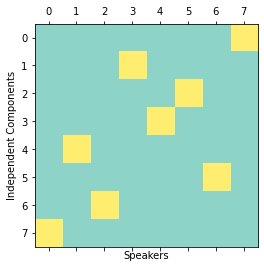

In [277]:
import numpy as np
import matplotlib.pyplot as plt

# plt.imshow(pred)
# plt.colorbar()
# plt.show()
plt.matshow(pred, cmap='Set3')
plt.xlabel('Speakers')
plt.ylabel('Independent Components')
plt.show()

In [ ]:
speakers_list=[data_speaker0, data_speaker1, data_speaker2, data_speaker3, 
               data_speaker4, data_speaker5, data_speaker6, data_speaker7]
    
speakers_list

In [ ]:
j=0
for com in components_list:
    print("Independent Component"+" " + str(j))
    ipd.display(ipd.Audio(com)) 
    print("Original Speaker"+" "+str(predictions[j]))
    ipd.display(ipd.Audio(speakers_list[predictions[j]], rate=rate0))
    j+=1
    print("----------------------------------------------")

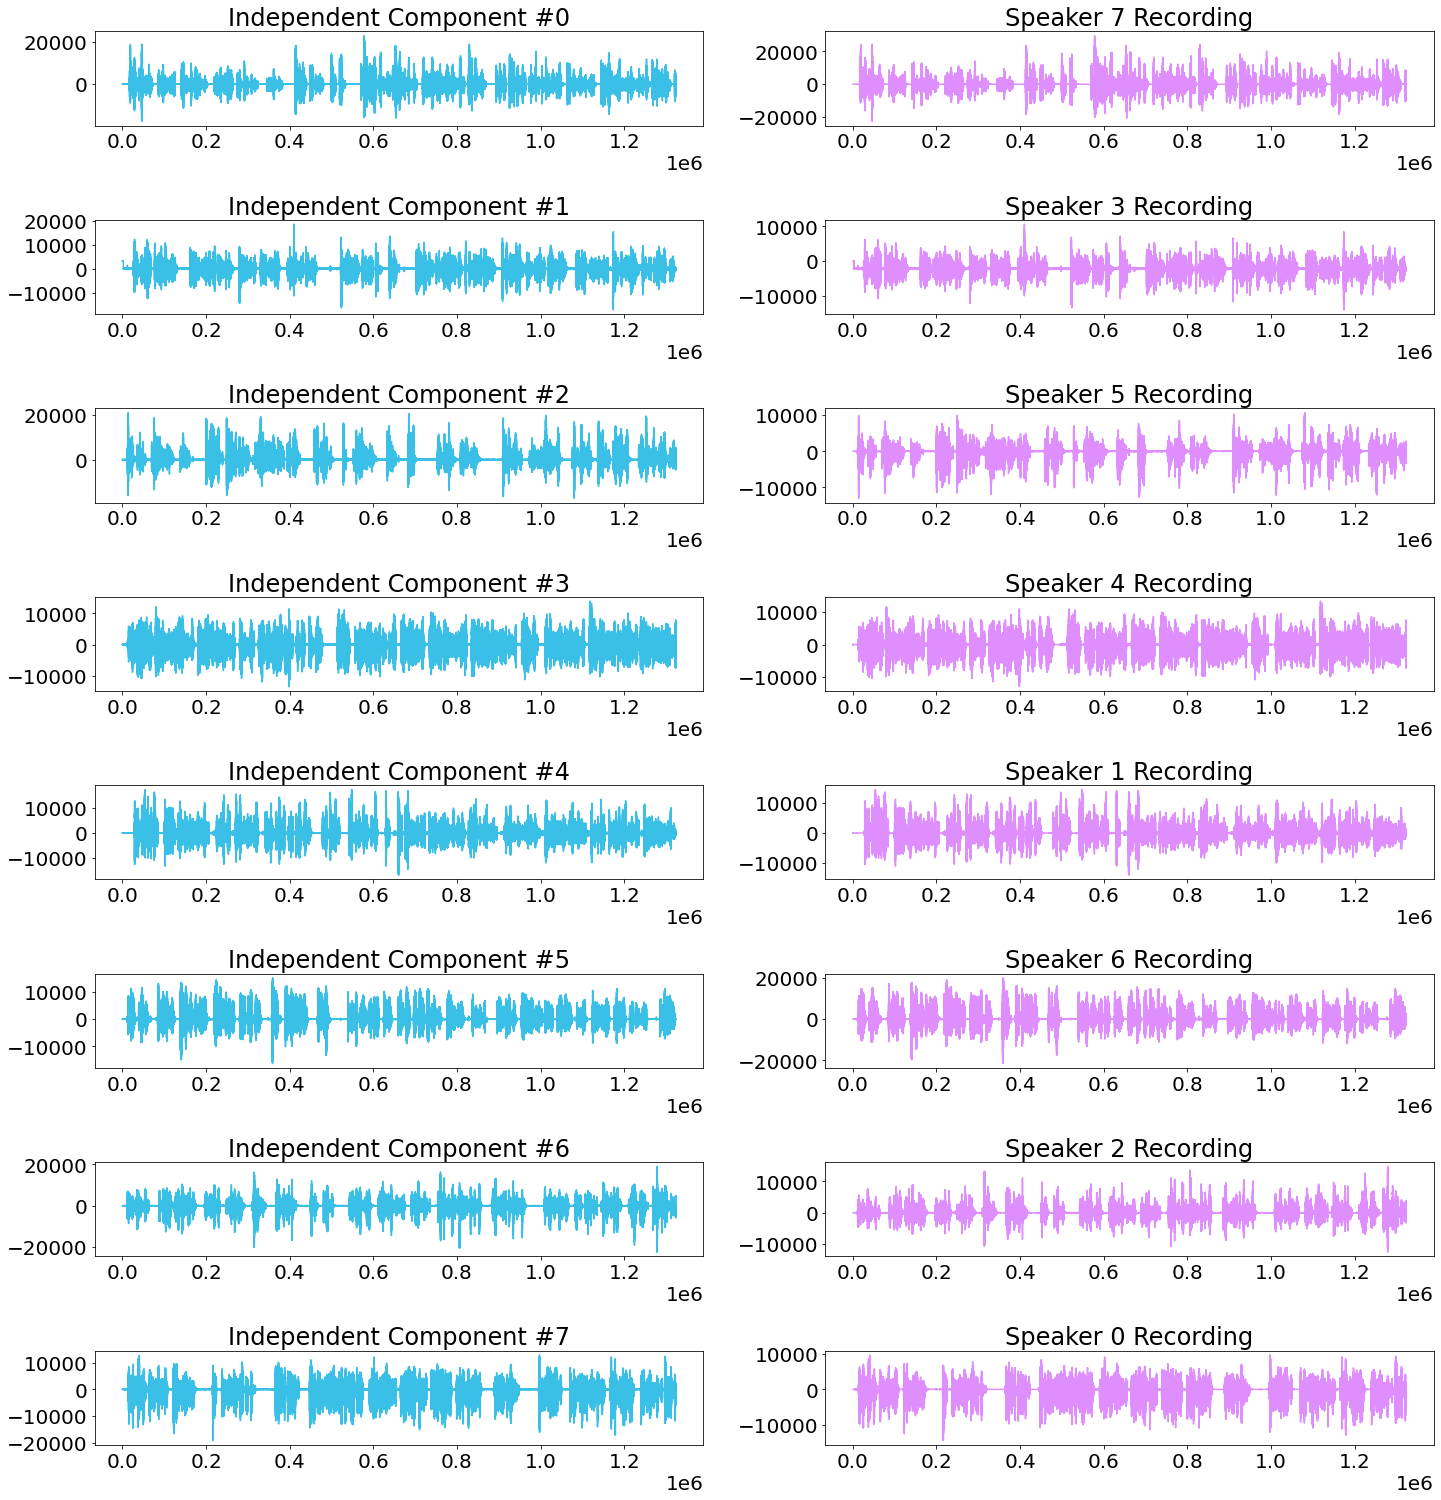

In [339]:
plt.figure(figsize=(24,26))

fig = plt.subplot(8, 2, 1)
plt.title('Independent Component #0')
plt.plot(result_signal_0, c="#3ABFE7")

fig = plt.subplot(8, 2, 2)
plt.title('Speaker 7 Recording')
plt.plot(data_speaker7, c="#df8efd")

fig = plt.subplot(8, 2, 3)
plt.title('Independent Component #1')
plt.plot(result_signal_1, c="#3ABFE7")

fig = plt.subplot(8, 2, 4)
plt.title('Speaker 3 Recording')
plt.plot(data_speaker3, c="#df8efd")

fig = plt.subplot(8, 2, 5)
plt.title('Independent Component #2')
plt.plot(result_signal_2, c="#3ABFE7")

fig = plt.subplot(8, 2, 6)
plt.title('Speaker 5 Recording')
plt.plot(data_speaker5, c="#df8efd")

fig = plt.subplot(8, 2, 7)
plt.title('Independent Component #3')
plt.plot(result_signal_3, c="#3ABFE7")

fig = plt.subplot(8, 2, 8)
plt.title('Speaker 4 Recording')
plt.plot(data_speaker4, c="#df8efd")

fig = plt.subplot(8, 2, 9)
plt.title('Independent Component #4')
plt.plot(result_signal_4, c="#3ABFE7")

fig = plt.subplot(8, 2, 10)
plt.title('Speaker 1 Recording')
plt.plot(data_speaker1, c="#df8efd")

fig = plt.subplot(8, 2, 11)
plt.title('Independent Component #5')
plt.plot(result_signal_5, c="#3ABFE7")

fig = plt.subplot(8, 2, 12)
plt.title('Speaker 6 Recording')
plt.plot(data_speaker6, c="#df8efd")

fig = plt.subplot(8, 2, 13)
plt.title('Independent Component #6')
plt.plot(result_signal_6, c="#3ABFE7")

fig = plt.subplot(8, 2, 14)
plt.title('Speaker 2 Recording')
plt.plot(data_speaker2, c="#df8efd")

fig = plt.subplot(8, 2, 15)
plt.title('Independent Component #7')
plt.plot(result_signal_7, c="#3ABFE7")

fig = plt.subplot(8, 2, 16)
plt.title('Speaker 0 Recording')
plt.plot(data_speaker0, c="#df8efd")

plt.rcParams.update({'font.size': 10})

plt.subplots_adjust(hspace=1)
plt.show()